### To Be Continued ...

### Imports

In [1]:
import torch.nn as nn
import pandas as pd
import torch
import torchvision as tv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
from skimage.metrics import structural_similarity as ssim
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
watermark_path = 'D:/allforwork/AI/nnsp/NS-2025-01-data/Train/alpha_20000'
wm_img_path = 'D:/allforwork/AI/nnsp/NS-2025-01-data/Train/Watermarked_image_20000'
img_path = 'D:/allforwork/AI/nnsp/NS-2025-01-data/Train/Watermark_free_image_20000'

In [ ]:
wm = np.array(Image.open(f'{watermark_path}/1.jpg'))
print(wm.shape)
print(wm)
wm_img = np.array(Image.open(f'{wm_img_path}/1.jpg'))
print(wm_img.shape)

In [15]:
wm = Image.open(f'{watermark_path}/1.jpg').convert("RGB")
wm_img = Image.open(f'{wm_img_path}/1.jpg').convert("RGB")
img = Image.open(f'{img_path}/1.jpg').convert("RGB")

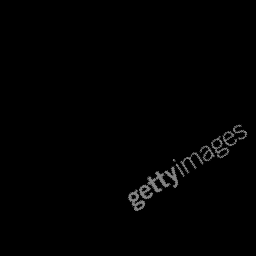

In [16]:
wm

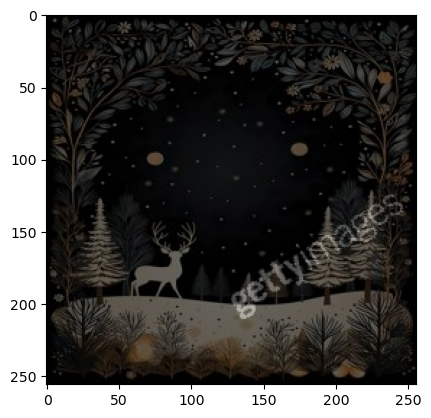

In [17]:
alpha = .6
test_img = np.array(wm) * (alpha) + np.array(img) * (1.0 - alpha)
test_img = np.int64(test_img)
plt.imshow(test_img)

### Prepare the Dataset

In [3]:
my_transform = tv.transforms.ToTensor()

dataset_size = 20000

dataset = []

for i in range(dataset_size):
    wm = f'{watermark_path}/{i + 1}.jpg'
    wm_img = f'{wm_img_path}/{i + 1}.jpg'
    img = f'{img_path}/{i + 1}.jpg'
    dataset.append((wm_img,wm,img))

In [4]:
val_p = .2
batch_siz = 16

train_siz = math.floor(dataset_size * (1 - val_p))
random.shuffle(dataset)

train_dataset = []
val_dataset = []

for i in range(0, train_siz, batch_siz):
    # print("batch", i)
    train_dataset.append((torch.cat([torch.cat([my_transform(np.array(Image.open(dataset[j][0]).convert("RGB"))), my_transform(np.array(Image.open(dataset[j][1])))]).unsqueeze(0) for j in range(i, min(train_siz, i + batch_siz))]), 
                         torch.cat([my_transform(np.array(Image.open(dataset[j][2]).convert("RGB"))).unsqueeze(0) for j in range(i, min(train_siz, i + batch_siz))])))

for i in range(train_siz, dataset_size, batch_siz):
    val_dataset.append((torch.cat([torch.cat([my_transform(np.array(Image.open(dataset[j][0]).convert("RGB"))), my_transform(np.array(Image.open(dataset[j][1])))]).unsqueeze(0) for j in range(i, min(dataset_size, i + batch_siz))]), 
                         torch.cat([my_transform(np.array(Image.open(dataset[j][2]).convert("RGB"))).unsqueeze(0) for j in range(i, min(dataset_size, i + batch_siz))])))

In [5]:
len(train_dataset)

1000

### Model

In [18]:
net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=False, scale=0.5)

d:\Anaconda\envs\sklearn-env\Lib\site-packages\torch\hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/milesial/Pytorch-UNet/zipball/master" to C:\Users\47328/.cache\torch\hub\master.zip


In [ ]:
print(net)

In [14]:
class AttentionGate(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels//2, 1)
        self.key = nn.Conv2d(in_channels, in_channels//2, 1)
        self.psi = nn.Sequential(
            nn.Conv2d(in_channels//2, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, g):
        # 门控注意力机制
        theta_x = self.query(x)
        phi_g = self.key(g)
        psi = nn.ReLU(theta_x + phi_g)
        return x * self.psi(psi)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.InstanceNorm2d(channels)
        )
        
    def forward(self, x):
        return x + self.conv(x)  # 残差学习

class WatermarkRemover(nn.Module):
    def __init__(self):
        super().__init__()
        # 下采样
        self.down1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        # 中间层（含注意力）
        self.mid_conv = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            ResidualBlock(256)
        )
        # 上采样
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        # 输出层（同时预测RGB和Alpha）
        self.final = nn.Conv2d(64, 4, 3, padding=1)
        
    def forward(self, x):
        # 完整前向传播流程
        x1 = self.down1(x)  # [64,256,256]
        x2 = self.down2(nn.MaxPool2d(kernel_size=2, stride=2)(x1))  # [128,128,128]
        x3 = self.mid_conv(nn.MaxPool2d(kernel_size=2, stride=2)(x2))  # [256,64,64]
        
        x = self.up1(x3, x2)  # 带跳跃连接
        x = self.up2(x, x1)
        return torch.sigmoid(self.final(x))  # 输出归一化到[0,1]

In [28]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.unet = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            ResidualBlock(256),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=4, kernel_size=1)

        )
        
    def forward(self, x):
        # 完整前向传播流程
        return torch.sigmoid(self.unet(x))  # 输出归一化到[0,1]

In [31]:
class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.alpha_weight = 0.3  # Alpha通道损失权重

    def forward(self, pred, target):
        # 分解目标
        target_rgb = target[:, :3, :]
        target_alpha = target[:, 3:, :]
        
        # RGB损失
        rgb_l1 = self.l1(pred[:, :3, :], target_rgb)
        rgb_ssim = 1 - ssim(pred[:, :3, :].cpu().numpy(), target_rgb.cpu().numpy(), win_size=11)
        
        # Alpha损失（Dice系数优化边缘）
        alpha_loss = 1 - (2*(pred[:,3, :]*target_alpha).sum() / 
                      (pred[:,3,:].pow(2).sum() + target_alpha.pow(2).sum() + 1e-6))
        
        # 动态权重组合
        total_loss = (0.5*rgb_l1 + 0.3*rgb_ssim + self.alpha_weight*alpha_loss)
        return total_loss

In [32]:
model = SimpleCNN()

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = model.to(device)
loss_fn = HybridLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
loss_log = []

Using cuda device


In [ ]:

epochs = 20
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    
    # Train
    model.train()
    siz = train_siz
    for t, (y, X) in enumerate(train_dataset):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        
        current = t * batch_siz + len(X)
        if t%50 == 0:
            print(f'loss: {loss.item():>7f} [{current:>5d}/{siz:>5d}]')


    # Eval
    model.eval()
    siz = len(dataset_size-train_siz)
    num_batches = len(val_dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (y, X) in val_dataset:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    loss_log.append(test_loss)
    correct /= siz
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")